## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

# My Solution to the exercise

This notebook contains my approach to solve the assignment given to applicants of a Data Scientist role at Starbucks. I will start with a look at the data, in particular the distributions of the features provided based on purchase decision and people being in control/treatment groups. I will then look at the question if the current data supports whether the treatment is effective, i.e. if there is a significant increase in purchases/IIR and NIR compared to the control group. Finally, I will develop a model to improve the selection of customers that receive the promotion, such that an improved incremental performance is acheived.

## Step 1: Exploratory data analysis

### Load necessary packages

In [212]:
import warnings
# needed to supress nasty catboost warnings:
warnings.simplefilter(action='ignore', category=FutureWarning)

from test_results import test_results, score
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline

### Load data and explore

Load the data and just print the first few elements to get a first look

In [172]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


Use `describe` method of `pandas` package to get an idea of the range of each feature as well as insights into some parameters of their distributions

In [173]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [174]:
train_data.dtypes

ID             int64
Promotion     object
purchase       int64
V1             int64
V2           float64
V3           float64
V4             int64
V5             int64
V6             int64
V7             int64
dtype: object

From the printouts, we can see that the dataset contains 10 features with the following characteristics:

- **"ID"** (integer): A unique ID for each customer
- **"Promotion"** (string): A "Yes"/"No" string that tells us whether the customer received the promotion (i.e. was in the treatment group) or not (control group)
- **"purchase"** (integer): A one-hot encoded column that tells us whether the customer purchased the product
- **"V1"** (integer): An integer feature ranging from 0 to 3
- **"V2"** (float): A continuous feature. We can't tell much about it at this point.
- **"V3"** (float): A continuous feature. Again not much to say at this point. It includes both negative and positive values. Maximum and minimum are within a similar range from zero.
- **"V4"** (integer): Again an integer feature. This one can only take values of 1 and 2
- **"V5"** (integer): Integer feature ranging from 1 to 4
- **"V6"** (integer): Integer feature ranging from 1 to 4
- **"V7"** (integer): Again an integer feature taking values of either 1 or 2

We can see that our dataset contains many "categorical" features, i.e. integer-valued numerical features that take up only a small set of values. It could for example be that originally this dataset contained many (string) categorical variables (e.g. "Frequency of customer interaction with the Starbucks website/app - daily, weekly, monthly, less than monthly") that were then already turned into an integer-based format for us. The high occurrence of such features in our dataset impacts the decision I made for the algorithm that is later used for developing a model selecting the "optimal" customers to maximise IIR and NIR.

### Make some plots

Next, I want to take a look at the distribution of all those available features. In the cell below, I coded up is a function that will create a plot with two rows and four columns of subplots, each of which (except for the last cell since there are only 7 features) will show the distribution of the respective feature, starting from "V1" to "V7". 

In [175]:
def plot_data(df_one, df_two=None, label_one=None, label_two=None,
              log_scale=False, normalize=False):
    """Create a plot of input distributions
    
    This function creates a 2x4 grid of plots, each of which shows the 
    distribution of the features 'V1' to 'V7' given in this assignment. The 
    final (bottom right) plot is left empty. It is possible to either plot the 
    distributions as they are or plot distributions of two different 
    DataFrames against each other.
    
    Args:
        df_one (pandas.DataFrame): Pandas DataFrame of which the distributions 
            should be plotted.
        df_two (pandas.DataFrame, optional): Optional dataframe to compare 
            distributions against `df_one`.
        label_one (:obj:`str`, optional): Plot label for data in DataFrame 
            `df_one` (only relevant if both `df_one` and `df_two` are 
            provided).
        label_two (:obj:`str`, optional): Plot label for data in DataFrame 
            `df_two`.
        log_scale (bool, optional): Whether or not the y axis scale should be 
            logarithmic. Default is False.
        normalize (bool, optional): Whether data distributions should be 
            normalized when plotted. Makes most sense to set when comparing 
            distributions of datasets with different amount of datapoints. 
            Default is False.
    
    Returns:
        None
    """

    fig, ax = plt.subplots(2,4, figsize=(24, 8))
    plot_counter = 0

    for col in df_one.columns:
        if not col.startswith("V"):
            continue
        
        row_idx = np.floor(plot_counter/4).astype(int)
        col_idx = plot_counter % 4
        
        plt.sca(ax[row_idx, col_idx])
        if train_data[col].dtype == int:
            if df_two is not None:
                tmp_data = df_one[col].value_counts()
                tmp_data_two = df_two[col].value_counts()
                if normalize:
                    y_vals_one = np.array(tmp_data.values)/np.array(tmp_data.values).sum()
                    y_vals_two = np.array(tmp_data_two.values)/np.array(tmp_data_two.values).sum()
                else:
                    y_vals_one = np.array(tmp_data.values)
                    y_vals_two = np.array(tmp_data_two.values)
                
                plt.bar(np.array(tmp_data.index), y_vals_one,
                        align="center", label=label_one, facecolor="None",
                        edgecolor="blue", linewidth=1)
                plt.bar(np.array(tmp_data_two.index), y_vals_two,
                        align="center", label=label_two, facecolor="None",
                        edgecolor="orange", linewidth=1)
            else:
                tmp_data = df_one[col].value_counts()
                plt.bar(np.array(tmp_data.index), np.array(tmp_data.values),
                        align="center", label=col)
            plt.ylabel("Frequency")
            plt.xlabel(col)
            plt.legend(loc="best")
            if log_scale:
                plt.yscale("log")
        else:
            if df_two is not None:
                full_min = np.min((df_one[col].min(), df_two[col].min()))
                full_max = np.max((df_one[col].max(), df_two[col].max()))
                bins = np.linspace(full_min, full_max, 100)
                df_one[col].plot.hist(label=label_one, bins=bins,
                                      histtype="step", density=normalize)

                df_two[col].plot.hist(label=label_two, bins=bins,
                                      histtype="step", density=normalize)
            else:
                df_one[col].plot.hist()
                
            if normalize:
                plt.ylabel("Frequency (Normalized)")
            else:
                plt.ylabel("Frequency")

            plt.xlabel(col)
            plt.legend(loc="best")
            if log_scale:
                plt.yscale("log")
        
        plot_counter += 1

    plt.show()
    plt.close()

First, I will use `plot_data` to get an idea of the full distributions of all features, without looking at any sub-divisions of the data:

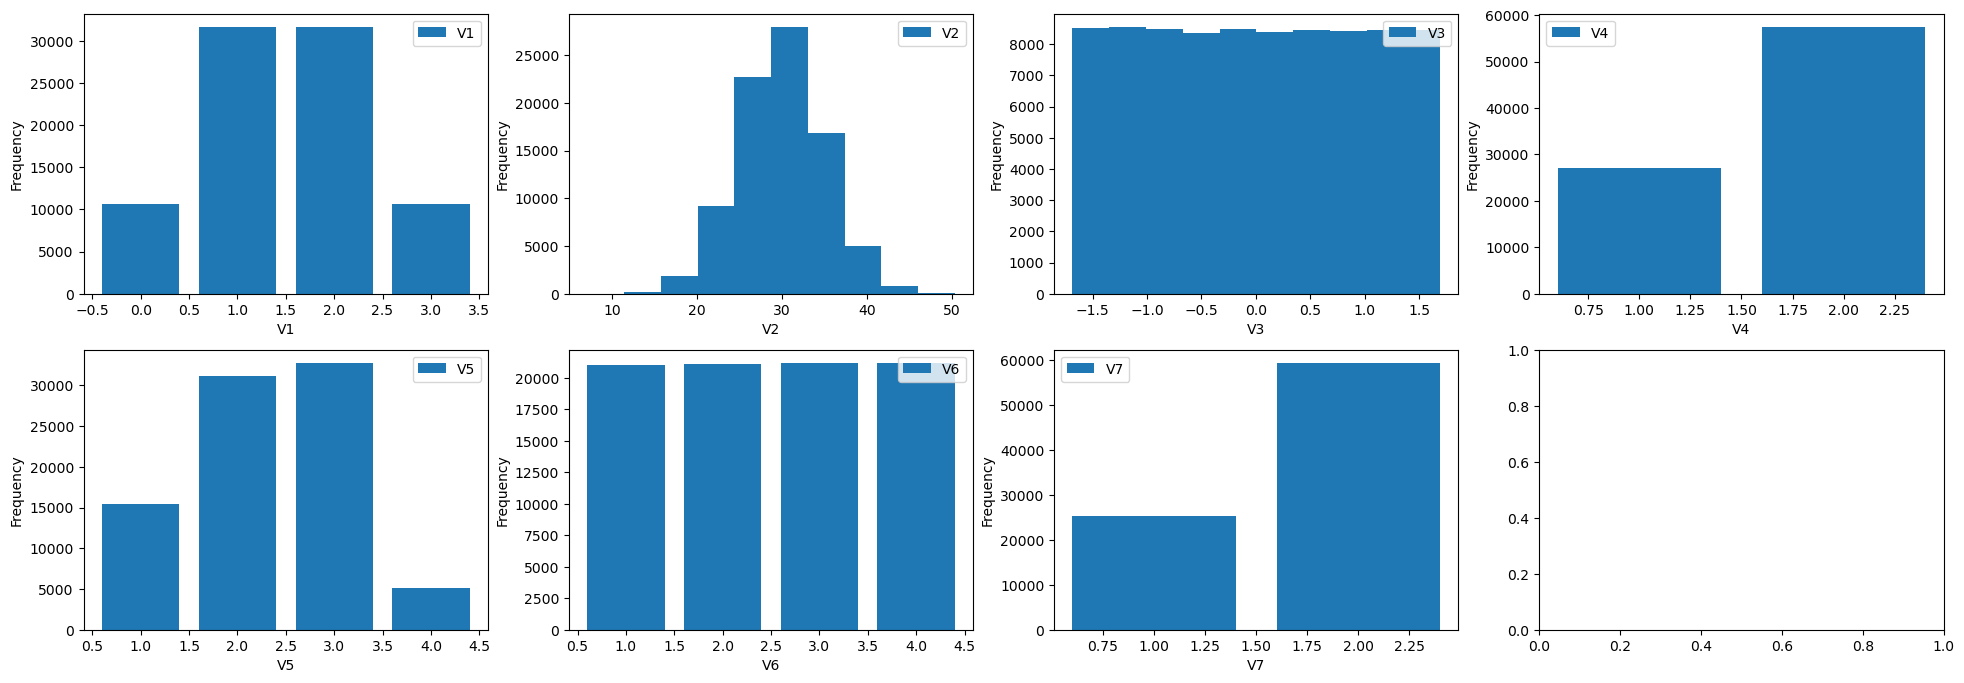

In [176]:
plot_data(train_data)

Some basic observations:

- "V2" seems to be some kind of Gaussian feature with a mean around 30
- "V3" seems to follow a uniform distribution
- "V1" and "V5" as well as "V4" and "V7" have a very similar distribution
- "V6" almost contains the exact same number of customers in each possible bin

However, these plots just give an overall picture. I am more interested in the differences between different groups of customers and how the distributions change accordingly.
Next, let's take a look how the distributions of the control and treatment groups compare. For a better granularity when comparing two groups, I increased the bin counts so subtle changes are also visible to us:

In [177]:
# split dataframe in control group and experiment/treatment group
df_exp = train_data[train_data["Promotion"] == "Yes"]
df_ctrl = train_data[train_data["Promotion"] == "No"]

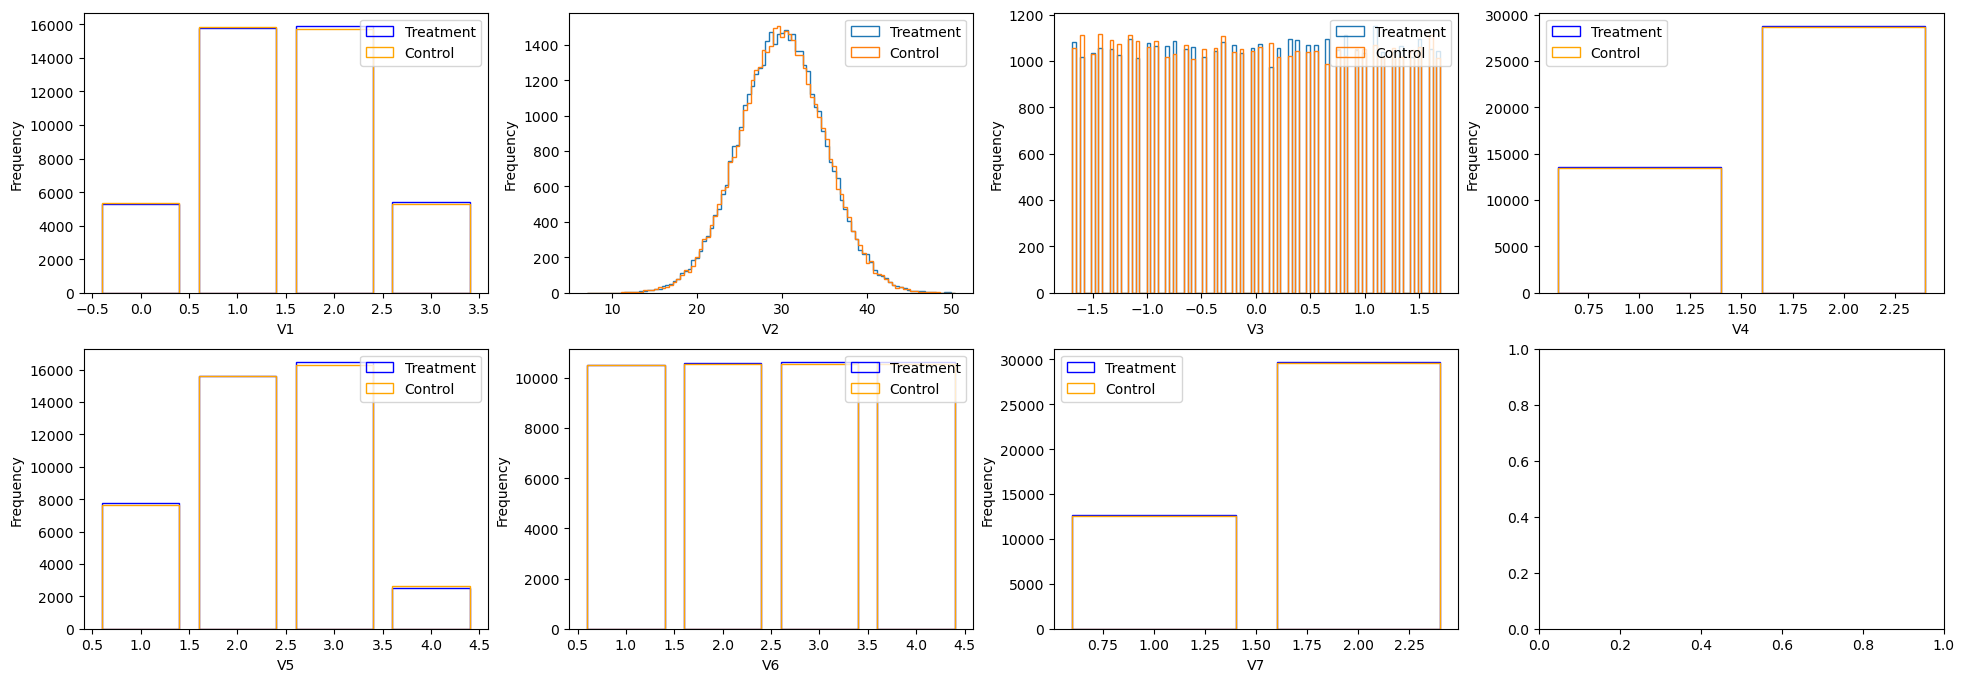

In [178]:
# plot distributions for treatment and control group separately
plot_data(df_exp, df_two=df_ctrl, label_one="Treatment", label_two="Control")

As we can see, at a first glance the feature distributions of treatment and control groups look rather similar. Some difference can be seen in the `V3` feature, where customers in the treatment group seem to trend towards higher postive values, while the control group is more on the negative side. Also for `V3`, we now see due to the smaller bins that the feature is somewhat pseudo-categorical. It *is* a floating point number feature, but only certain values are taken.

Do these plots mean that the treatment and control groups are more or less the same, i.e. are the features unaffected by the treatment? Not necessarily! Just because the distributions look similar, it doesn't mean that we'll see the same behavior once it comes to actually purchasing the product. Also, we need to keep in mind that we only see the 1D marginal distributions of each feature here and not their high-dimensional, possibly nonlinear correlations!

To investigate this further, let's look at the distributions of customers that purchased vs. those that didn't purchase our product. We'll start with customers in the **control group** first:

In [179]:
# separate control group in those who purchased the product 
# and those who didn't
df_ctrl_purch = df_ctrl[df_ctrl["purchase"] == 1]
df_ctrl_nopurch = df_ctrl[df_ctrl["purchase"] == 0]

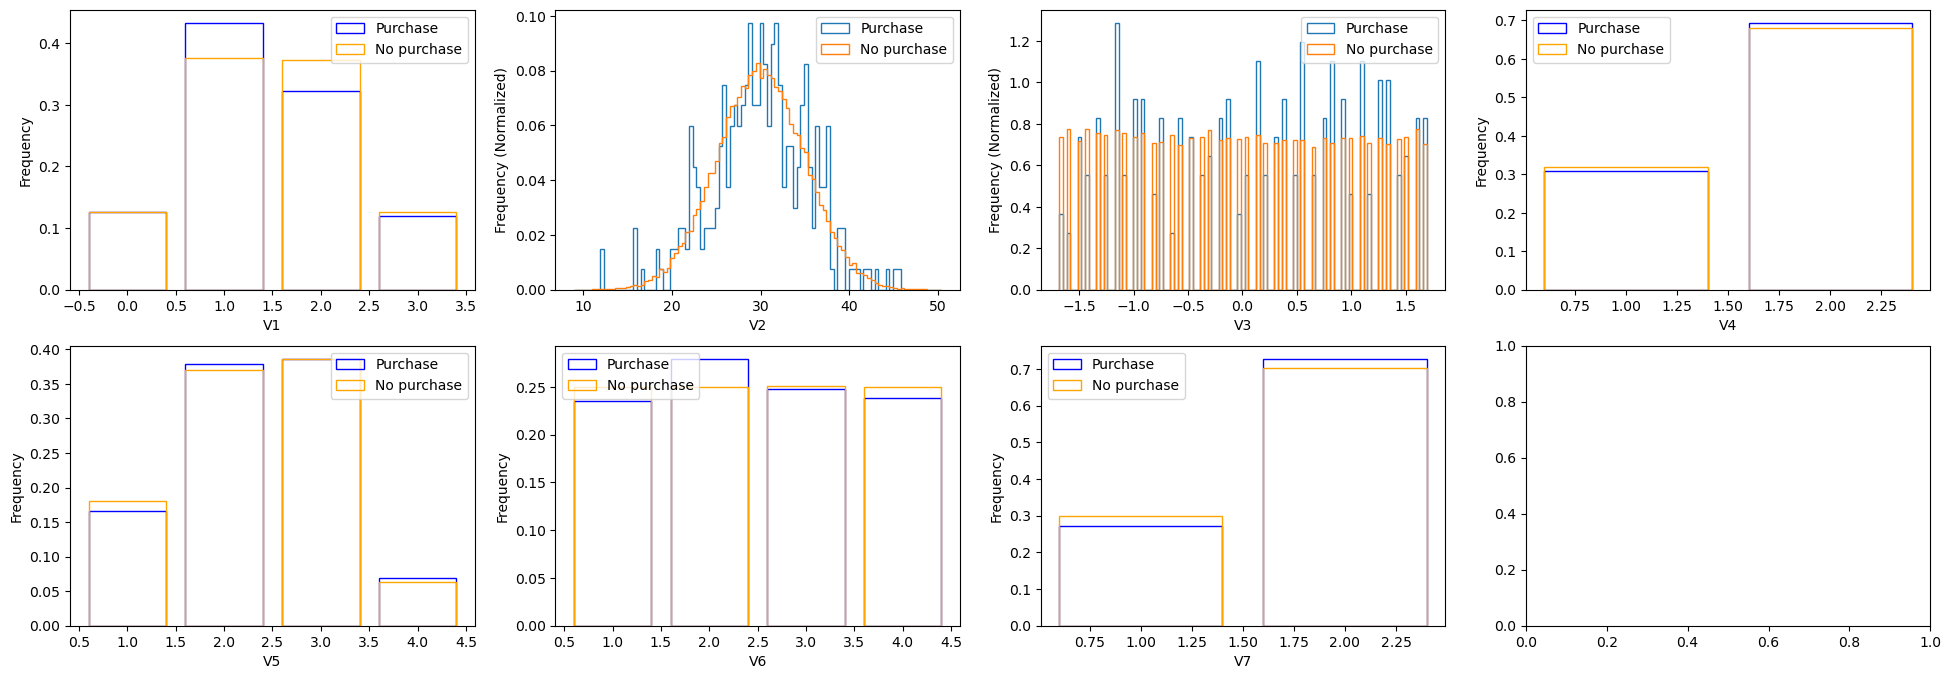

In [180]:
plot_data(df_ctrl_purch, df_two=df_ctrl_nopurch, label_one="Purchase",
          label_two="No purchase", normalize=True)

Some observations:

- most "categorical" features look similar between purchasing and non-purchasing customers
- In `V6`, there are way more purchasing customers in the bin at 2 than non-purchasing ones
- In `V1`, there are way more purchasing customers in the bin at 1 than non-purchasing ones and vice-versa for the bin at value 2
- The differences in `V1` and `V6` seem the most striking amongst integer-valued features
- For `V2`, it is difficult to say whether there is a significant difference due to the limited statistics of purchasing customers
- For `V3`, it seems more purchasing customers are at the positive side of the values while there are fewer high bins on the negative side
- Also for `V3`, the bin content of non-purchasing customers seems to stay rather uniform across the value range

Now let's look at the same plots for the **treatment** group:

In [181]:
# separate treatment group into customers that purchased the product and
# those who didn't
df_exp_purch = df_exp[df_exp["purchase"] == 1]
df_exp_nopurch = df_exp[df_exp["purchase"] == 0]

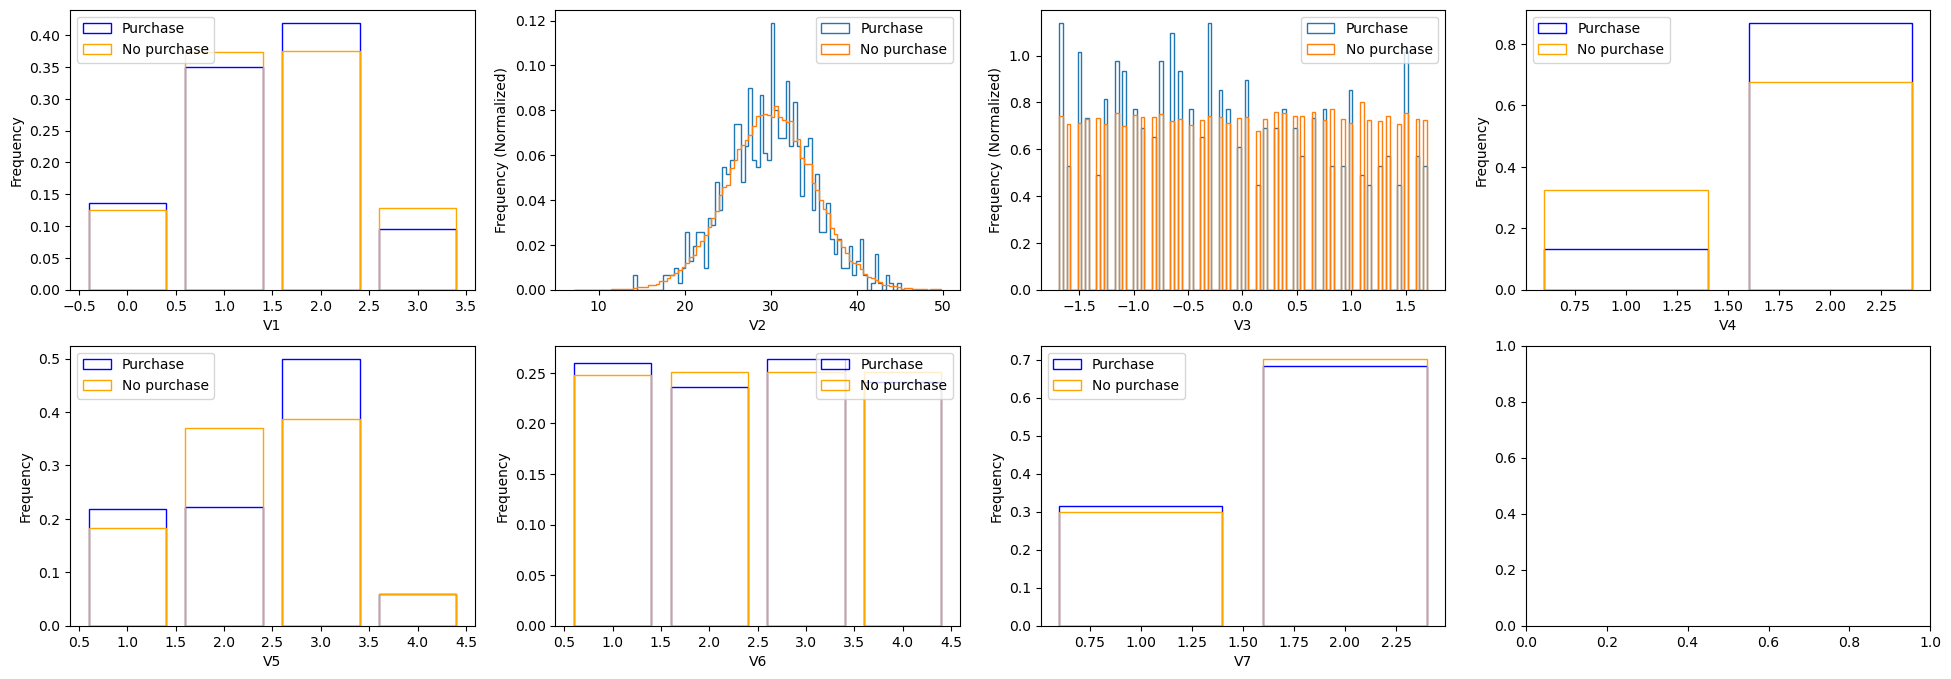

In [182]:
# plot individual distributions
plot_data(df_exp_purch, df_two=df_exp_nopurch, label_one="Purchase",
          label_two="No purchase", normalize=True)

These are extremely interesting plots! They look *very* similar to those of the experimental group! Some aspects:

- In general, there is a much larger difference in bin content for the categorical features between purchasing and non-purchasing groups
- For `V1`, the bin at value 2 is significantly higher for purchasing customers than for non-purchasing ones
- For `V5` there is a huge difference between groups at bins with values 2 and 3
- There is also a significant difference visible in both bins of feature `V4`, which was not the case for the control group
- Also contrary to the control group, bins in `V3` are now higher on the negative side of the distribution for the group of customers that purchased our product, which is the opposite result of what we discussed for the control group
- For `V2`, the overall distributions look rather similar (modulo the small statistics issue that we also had in the control group plot)
- Features `V6` and `V7` are rather similar for purchasing and non-purchasing customers



These results show that, even though the *overall* distribution of features `V1` to `V7` look similar when comparing control and treatment groups, this is not true when looking at the *purchasing* behavior of our customers - which is the actual thing we want to influence with our promotion. Let's solidify this finding by doing a final comparison: the customers purchasing our product in the treatment vs. in the control group:

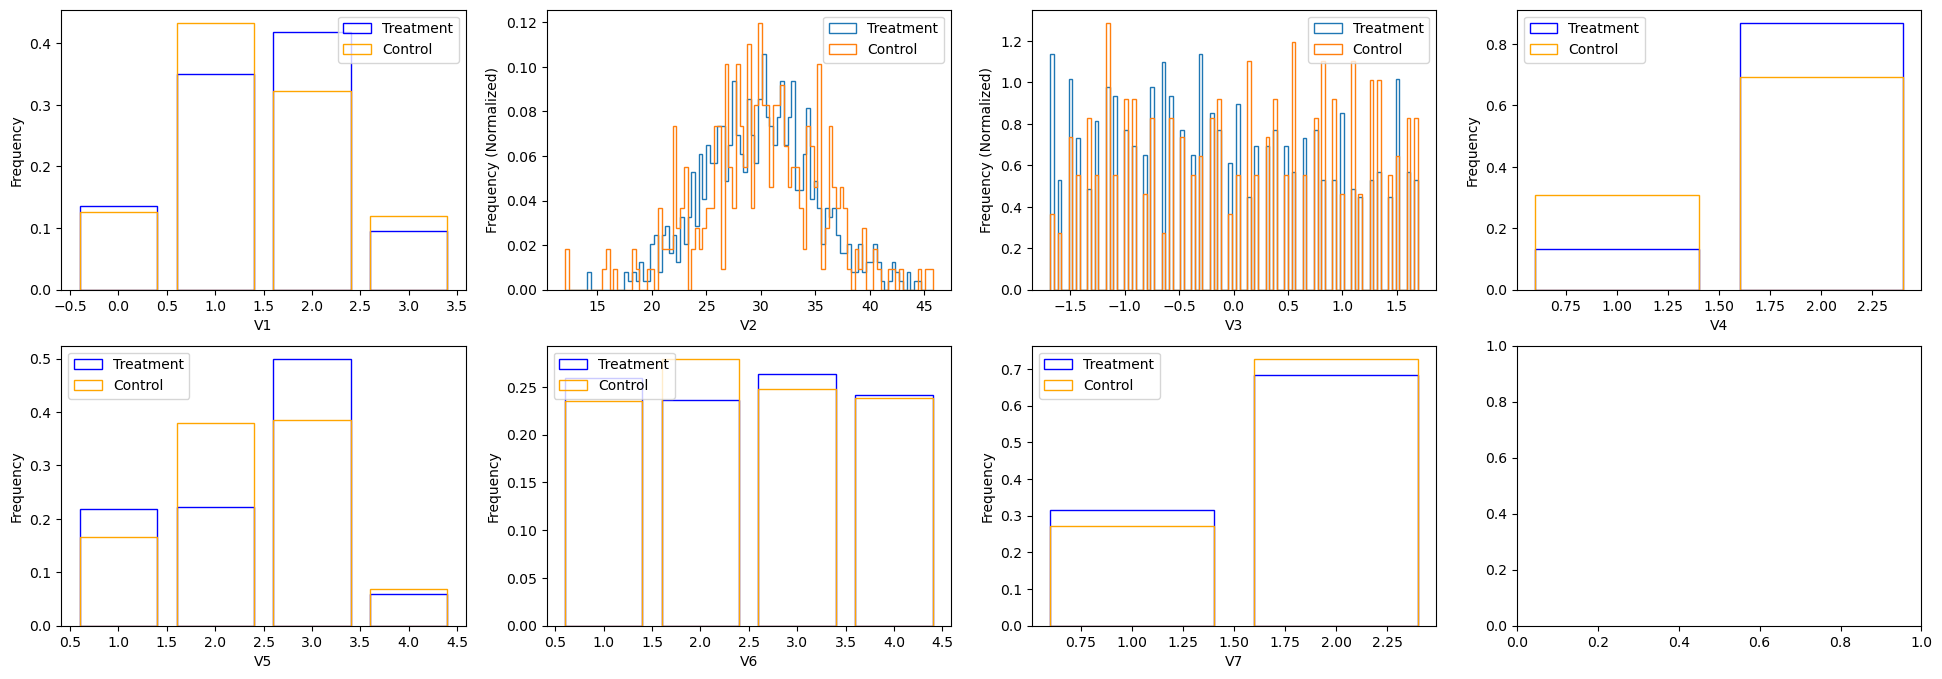

In [183]:
plot_data(df_exp_purch, df_two=df_ctrl_purch, label_one="Treatment",
          label_two="Control", normalize=True)

We clearly see significant differences in almost all features, except maybe in `V2` and `V7`, where differences are more subtle or more difficult to compare directly. Thus we can state that there is a difference in purchasing behaviour that is reflected in the features for customers in the control and treatment groups.

# Step 2: Analyze results of experiment

Now that we thoroughly explored all the features and distributions based on several selections, let's start with the actual assignment:

### Question 1: Analyze the results of the experiment and identify the effect of the treatment on product purchase and Net Incemental Revenue

However, before we deep-dive into the *actual* analysis, let's take a look if we need to run any data cleaning first by investigating whether there exist `NaN` or `INF` values in our feature columns:

In [184]:
for col in train_data.columns:
    if not col.startswith("V"):
        continue
    n_infs = (~np.isfinite(train_data[col])).sum()
    print(f"Number of NaN/INF samples in column {col}: {n_infs}")

Number of NaN/INF samples in column V1: 0
Number of NaN/INF samples in column V2: 0
Number of NaN/INF samples in column V3: 0
Number of NaN/INF samples in column V4: 0
Number of NaN/INF samples in column V5: 0
Number of NaN/INF samples in column V6: 0
Number of NaN/INF samples in column V7: 0


Our dataset seems already clean! Now we can start with the analysis!

Two major questions need to be discussed to answer question 1:

1.) is there actually an incremental response that we can observe?
2.) if 1) is true: is this change significant?

We start by answering question number one:

In [185]:
p_exp = (df_exp["purchase"]==1).sum()/df_exp.shape[0]
p_ctrl = (df_ctrl["purchase"]==1).sum()/df_ctrl.shape[0]
irr_base = p_exp - p_ctrl
print(f"The IRR for our data is: {irr_base:.4f}")

The IRR for our data is: 0.0095


That's about a 1% increase. Let's answer part 2.) and see if that's a significant difference!

In [186]:
p_combined = (train_data["purchase"]==1).sum()/train_data.shape[0]
sd_combined = np.sqrt(p_combined*(1-p_combined)*((1/df_exp.shape[0]) + (1/df_ctrl.shape[0])))
z_score = irr_base/sd_combined

print(f"Z score is: {z_score}")

Z score is: 12.468449461599388


In [187]:
p_value = 1-norm.cdf(z_score)
print(f"P-value: {p_value}")

P-value: 0.0


We see that there *is* a really significant difference! The p-value is basically zero (more precisely: closer to zero than the float precision limit)!

Now let's see what the corresponding NIR is:

In [188]:
nir_base = (10*(df_exp["purchase"]==1).sum())-(0.15*df_exp.shape[0])-(10*(df_ctrl["purchase"]==1).sum())
print(f"NIR is: {nir_base:.2f}")

NIR is: -2334.60


We see that the current promotional strategy is far from optimal. Even though we do see a significant increase in incremental response, the revenue generated from that is actually negative. So currently, Starbucks is loosing money sending out the promotion.

# Step 3: Build improved model

### Question 2: Build a model to select the best customers to target that maximizes the incremental response rate and net incremental revenue

In order to increase the IRR and NIR, we need to select the customers that most likely purchased the product when receiving the promotion. Thus, I will train a simple model only on the treatment group to predict if a customer will make a purchase or not. When it is evaluated on the test set, the targeted costumers receiving the promotion should have a higher probability of buying than in the case without the selection by the model. The control group costumers, however, should stay largely unaffected given their significantly different purchasing behavior, as previously discussed.

I will start with a simple linear model first. Below is a function to load in the data as necessary:

In [189]:
def load_data(train_columns, tgt_column, std_v2=False):
    """Function to customize data loading
    
    Args:
        train_columns (:obj:`list` of :obj:`str`): Column names to select 
            training features from pandas DataFrame
        tgt_column (:obj:`str`): Column name to use in the target
        std_v2 (bool, optional): Optional boolean value (default is False) 
            whether to standardize the feature 'V2' (i.e. subtract the mean and 
            divide by the standard deviation). Only appled if the 'V2' feature 
            is either in `train_columns` or the `tgt_column`
    
    Returns:
        A four-tuple of pandas.DataFrame instances, containing the following 
        elements:
        
        x_train: The input features of the training set
        y_train: The targets of the training set
        x_test: The input features of the test set
        y_test: The targets of the test set
    """
    
    if tgt_column in train_columns:
        print(("ERROR! You are setting the target column as one of your "
              "features! This is not recommended! Please choose a different "
              "target feature and retry!"))

    train_data = pd.read_csv('./training.csv')
    test_data = pd.read_csv('./Test.csv')
    
    feat = "Promotion"
    if (feat in train_columns) or (feat == tgt_column):
        train_data[f"{feat}_num"] = 0
        train_data[f"{feat}_num"][train_data[feat] == "Yes"] = 1
        train_data = train_data.drop(columns=[feat])
        train_data = train_data.rename(columns={f"{feat}_num": feat}
                                        )
        
        test_data[f"{feat}_num"] = 0
        test_data[f"{feat}_num"][test_data[feat] == "Yes"] = 1
        test_data = test_data.drop(columns=[feat])
        test_data = test_data.rename(columns={f"{feat}_num": feat})
    
    y_train = train_data[tgt_column]
    y_test = test_data[tgt_column]
    x_train = train_data[train_columns]
    x_test = test_data[train_columns]
    if "V2" in train_columns and std_v2:
        mean_v2 = x_train["V2"].mean()
        std_v2 = x_train["V2"].std()
        x_train["V2"] = (x_train["V2"]-mean_v2)/std_v2
        x_test["V2"] = (x_test["V2"]-mean_v2)/std_v2
    
    
    
    return x_train, y_train, x_test, y_test


At first, lets load the data using the `load_data` function:

In [190]:
# load data
train_cols = ["Promotion", "V1", "V2", "V3", "V4", "V5", "V6", "V7"]
tgt_col = "purchase"
x_train, y_train, x_test, y_test = load_data(train_cols, tgt_col)

# split into treatment/control groups
x_train_treat = x_train[x_train["Promotion"] == 1]
x_train_ctrl = x_train[x_train["Promotion"] == 0]
y_train_treat = y_train[x_train["Promotion"] == 1]
y_train_ctrl = y_train[x_train["Promotion"] == 0]

# do same for test set
x_test_treat = x_test[x_test["Promotion"] == 1]
x_test_ctrl = x_test[x_test["Promotion"] == 0]
y_test_treat = y_test[x_test["Promotion"] == 1]
y_test_ctrl = y_test[x_test["Promotion"] == 0]

# drop promotion column
x_train = x_train.drop(columns=["Promotion"])
x_test = x_test.drop(columns=["Promotion"])
x_train_treat = x_train_treat.drop(columns=["Promotion"])
x_train_ctrl = x_train_ctrl.drop(columns=["Promotion"])
x_test_treat = x_test_treat.drop(columns=["Promotion"])
x_test_ctrl = x_test_ctrl.drop(columns=["Promotion"])

/tmp/ipykernel_8394/3733297632.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[f"{feat}_num"][train_data[feat] == "Yes"] = 1
/tmp/ipykernel_8394/3733297632.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f"{feat}_num"][test_data[feat] == "Yes"] = 1


Check number of purchasing vs non-purchasing customers in training set:

In [191]:
np.unique(y_train_treat, return_counts=True)

(array([0, 1]), array([41643,   721]))

We see there is a large imbalance of non-purchasing vs. purchasing customers even in our treatment group. Thus we will use class weights in our model to account for this.

As for the algorithm to use: I usually always start with something simple and then test something more complex if I have the feeling that the performance can be improved significantly by adding more complexity. Here, I chose `scikit-learn`'s `LogisticRegression` for a start, which is a simple linear model:

In [192]:
# build simple model, use class weights to account for large imbalance of
# non-purchasing vs purchasing customers
model = LogisticRegression(class_weight='balanced', solver="newton-cholesky")

In [193]:
model.fit(x_train_treat, y_train_treat)

LogisticRegression(class_weight='balanced', solver='newton-cholesky')

Below, I defined functions to compute the NIR and IRR for different thresholds on our trained model output and also plot the two variables for different thresholds. The way the evaluation functions are implemented is inspired by how the functions in the `test_results.py` script are used that was provided by Udacity.

In [198]:
def compute_nir(df_promo):
    """Compute net incremental revenue (NIR)
    
    Args:
        df_promo (pandas.DataFrame): Pandas DataFrame containing 'Promotion' 
            column
    
    Returns:
        float: The NIR value
    """
    purch_treat = df_promo.loc[df_promo["Promotion"] == "Yes", "purchase"].sum()
    cust_treat = df_promo.loc[df_promo["Promotion"] == "Yes", :].shape[0]
    purch_ctrl = df_promo.loc[df_promo["Promotion"] == "No", "purchase"].sum()
    return (10*purch_treat)-(0.15*cust_treat)-(10*purch_ctrl)

def compute_irr(df_promo):
    """Compute incremental response rate (IRR)
    
    Args:
        df_promo (pandas.DataFrame): Pandas DataFrame containing 'Promotion' 
            column
    
    Returns:
        float: The IRR value
    """
    purch_treat = df_promo.loc[df_promo["Promotion"] == "Yes", "purchase"].sum()
    cust_treat = df_promo.loc[df_promo["Promotion"] == "Yes", :].shape[0]
    purch_ctrl = df_promo.loc[df_promo["Promotion"] == "No", "purchase"].sum()
    cust_ctrl = df_promo.loc[df_promo["Promotion"] == "No", :].shape[0]

    ratio_treat = purch_treat/cust_treat
    ratio_ctrl = purch_ctrl/cust_ctrl

    return ratio_treat - ratio_ctrl

def run_evaluation(model, set="test"):
    """Evaluation of model for Starbucks assignment
    
    This function takes a model and evaluates it (by default) on the provided
    test set. The NIR and IRR is computed for different thresholds on the 
    model output and then plotted. Also, several useful printouts about the 
    performance of the current model are shown
    
    Args:
        model: Scikit-learn model that shoud be evaluated.
        set (:obj:`str`, optional): Can be either 'train' or 'test' (default) 
            and defines which dataset to run the evaluation on.
    
    Returns:
        None
    """
    if set == "train":
        df = pd.read_csv("./training.csv")
    elif set == "test":
        df = pd.read_csv("./Test.csv")
    else:
        raise ValueError(("Error! `set` variable needs to be either "
                          "'train' or 'test'!"))

    use_cols = ["Promotion", "purchase",
                "V1", "V2", "V3", "V4", "V5", "V6", "V7"]

    df = df[use_cols]

    preds = model.predict_proba(
        df.drop(columns=["Promotion", "purchase"]))[:, 1]

    thresholds = np.linspace(0,1,1000)
    nir = []
    irr = []
    print(f"Number of thresholds: {thresholds.shape[0]}")
    num_checks = np.floor(thresholds.shape[0]/20)
    for i, thresh in enumerate(thresholds):
        if (i+1) % num_checks == 0:
            print(f"Done with {((i+1)/thresholds.shape[0])*100:.0f}%")

        mask = preds > thresh

        nir.append(compute_nir(df[mask]))
        irr.append(compute_irr(df[mask]))

    nir = np.array(nir)
    irr = np.array(irr)
    
    fig, ax = plt.subplots()
    ax.plot(thresholds, nir, color="blue")
    ax.set_xlabel("Model output", fontsize=14)
    ax.set_ylabel("NIR", color="blue", fontsize=14)

    ax2 = ax.twinx()
    ax2.plot(thresholds, irr, color="red")
    ax2.set_ylabel("IRR", color="red", fontsize=14)
    plt.show()
    plt.close()
    
    print(f"Maximum NIR is: {np.max(nir):.2f} at threshold"
          f" of model output {thresholds[np.argmax(nir)]:.3f}")
    
    print(f"IRR at maximum NIR: {(irr[np.argmax(nir)]*100):.2f}%")

Let's first take a look at the performance on the training set. Usually this is not done since one wants to have an idea of how well the model generalizes to previously unseen data - which would be the test set. However, we have a linear model here that has a high bias and rather low complexity, thus we don't expect the results to change too drastically for different samples here.

Number of thresholds: 1000
Done with 5%
Done with 10%
Done with 15%
Done with 20%
Done with 25%
Done with 30%
Done with 35%
Done with 40%
Done with 45%
Done with 50%
Done with 55%
Done with 60%
Done with 65%


/tmp/ipykernel_8394/4253764859.py:31: RuntimeWarning: invalid value encountered in long_scalars
  ratio_treat = purch_treat/cust_treat
/tmp/ipykernel_8394/4253764859.py:32: RuntimeWarning: invalid value encountered in long_scalars
  ratio_ctrl = purch_ctrl/cust_ctrl


Done with 70%
Done with 75%
Done with 80%
Done with 85%
Done with 90%
Done with 95%
Done with 100%


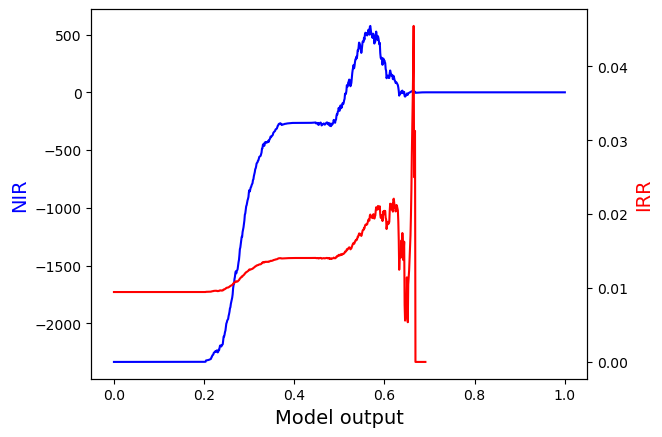

Maximum NIR is: 574.95 at threshold of model output 0.569
IRR at maximum NIR: 1.99%


In [199]:
run_evaluation(model, set="train")

As we can see, we have a good performance on the training set: Our NIR is about 575$ at the optimal threshold on the model output while our IIR is around 2%, which is also an improvement compared to the original treatment.

Now let's take a look at the test set:

Number of thresholds: 1000
Done with 5%
Done with 10%
Done with 15%
Done with 20%
Done with 25%
Done with 30%
Done with 35%
Done with 40%
Done with 45%
Done with 50%
Done with 55%
Done with 60%
Done with 65%
Done with 70%


/tmp/ipykernel_8394/4253764859.py:31: RuntimeWarning: invalid value encountered in long_scalars
  ratio_treat = purch_treat/cust_treat
/tmp/ipykernel_8394/4253764859.py:32: RuntimeWarning: invalid value encountered in long_scalars
  ratio_ctrl = purch_ctrl/cust_ctrl


Done with 75%
Done with 80%
Done with 85%
Done with 90%
Done with 95%
Done with 100%


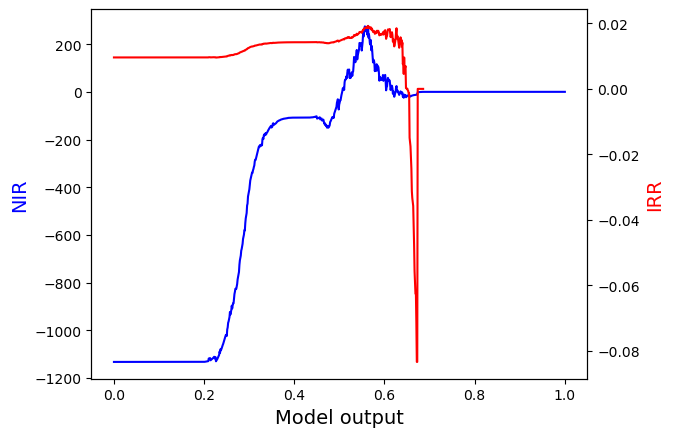

Maximum NIR is: 276.30 at threshold of model output 0.564
IRR at maximum NIR: 1.92%


In [200]:
run_evaluation(model, set="test")

This seems a very similar result as we saw with the training set: Our NIR is improved to around 275$ here, while the IIR is around 2% at the optimal threshold. Thus, it seems a simple linear model already gives a significant improvement over the original treatment. 

Also, since this is a linear model, we see that the optimal results are achieved at very similar thresholds on the model output, independent of the dataset. We could therefore just set the threshold around 0.56 and probably still get a positive NIR for any dataset.

# Step 4: Further improve model and analyze results

While the previous results are already good, I'd like to try a slightly more sophisticated approach and see if I can get an even better result compared to the linear approach. For this, I will use a tree-based algorithm, `catboost` to be precise. I choose this algorithm especially because from my experience it works well if there exist many categorical features and also it usually has great out-of-the-box performance.

At first, we build the model and again use class weights when doing so. I already inserted some hyperparameter settings that I found worked well by just trying around a little bit. I didn't do a full hyperparameter search though, so there might be still some room for even further improvement.

In [201]:
weights_train = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_treat),
                                     y=y_train_treat)

class_weights_train = dict(zip(np.unique(y_train_treat),
                               weights_train))

cat_model = CatBoostClassifier(task_type="GPU",
                               class_weights=class_weights_train,
                               depth=10, iterations=1000,
                               )

Note: we will use the test set as evaluation set here to achieve better results. Ideally one would use a separate validation dataset for this, since it is kind of "cheating" to use the same dataset we use for the final performance evaluation also in the model/iteration selection. However, the results are rather similar even without the eval set so the impact on the final result is marginal.

In [202]:
cat_model.fit(x_train_treat, y_train_treat,
              eval_set=(x_test_treat, y_test_treat),
              use_best_model=True)

Learning rate set to 0.051788
0:	learn: 0.6864802	test: 0.6872100	best: 0.6872100 (0)	total: 19ms	remaining: 19s
1:	learn: 0.6826076	test: 0.6832350	best: 0.6832350 (1)	total: 33.1ms	remaining: 16.5s
2:	learn: 0.6799268	test: 0.6808662	best: 0.6808662 (2)	total: 48.3ms	remaining: 16.1s
3:	learn: 0.6760564	test: 0.6772282	best: 0.6772282 (3)	total: 66.2ms	remaining: 16.5s
4:	learn: 0.6717808	test: 0.6732859	best: 0.6732859 (4)	total: 92.7ms	remaining: 18.5s
5:	learn: 0.6701682	test: 0.6714771	best: 0.6714771 (5)	total: 106ms	remaining: 17.5s
6:	learn: 0.6667314	test: 0.6679962	best: 0.6679962 (6)	total: 120ms	remaining: 17s
7:	learn: 0.6620212	test: 0.6650108	best: 0.6650108 (7)	total: 161ms	remaining: 20s
8:	learn: 0.6575958	test: 0.6631812	best: 0.6631812 (8)	total: 399ms	remaining: 43.9s
9:	learn: 0.6541112	test: 0.6598678	best: 0.6598678 (9)	total: 439ms	remaining: 43.5s
10:	learn: 0.6517708	test: 0.6580600	best: 0.6580600 (10)	total: 674ms	remaining: 1m
11:	learn: 0.6501877	test: 0

This time, we evaluate directly on the test set:

Number of thresholds: 1000
Done with 5%
Done with 10%
Done with 15%
Done with 20%
Done with 25%
Done with 30%
Done with 35%
Done with 40%
Done with 45%
Done with 50%
Done with 55%
Done with 60%
Done with 65%


/tmp/ipykernel_8394/4253764859.py:32: RuntimeWarning: invalid value encountered in long_scalars
  ratio_ctrl = purch_ctrl/cust_ctrl
/tmp/ipykernel_8394/4253764859.py:31: RuntimeWarning: invalid value encountered in long_scalars
  ratio_treat = purch_treat/cust_treat


Done with 70%
Done with 75%
Done with 80%
Done with 85%
Done with 90%
Done with 95%
Done with 100%


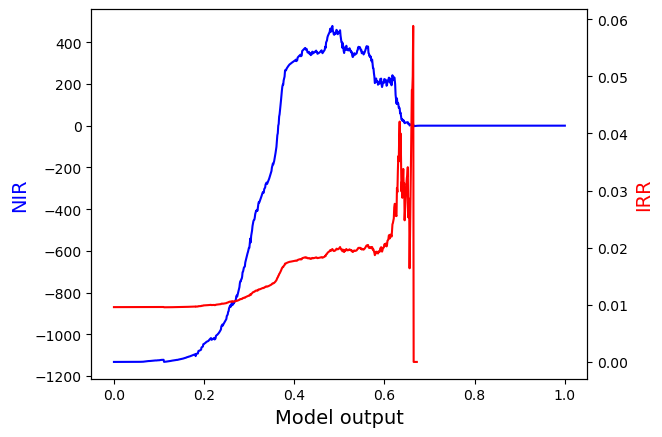

Maximum NIR is: 478.00 at threshold of model output 0.484
IRR at maximum NIR: 1.98%


In [203]:
run_evaluation(cat_model, set="test")

This looks like a significant improvement over the linear model: We see a NIR of around 475$ and the optimal value stays stable for a larger range of thresholds arounds 0.5. Also the IRR stays at a similar value as before, around 2%.

Now that we have our model, I want to investigate just a little bit more before we use it to fill the `promotion_strategy` function and finish up this assignment.

The first additional thing I would like to test is how our model performs in treatment vs control group of the test set. As we have seen in the beginning, the purchasing behaviour is significantly different in those two populations. Thus, I would expect a relatively good performance for the treatment group and almost random performance for the control group (AUC around 0.5):

In [204]:
auc_test_treat = roc_auc_score(y_test_treat,
                               cat_model.predict_proba(x_test_treat)[:, 1])

print(f"AUC score for treatment group, test set: {auc_test_treat:.2f}")

auc_test_ctrl = roc_auc_score(y_test_ctrl,
                              cat_model.predict_proba(x_test_ctrl)[:, 1])

print(f"AUC score for control group, test set: {auc_test_ctrl:.2f}")

AUC score for treatment group, test set: 0.67
AUC score for control group, test set: 0.52


We can see that my hypothesis was true. We do see a better performance in the treatment group (even though 0.67 isn't that good of an AUC score) while the control group's performance is almost random with the score being at 0.52.

Finally, one very cool thing to do with tree-based models like `catboost` is it allows access to some nice feature importance tools that tell us which of the features contributed most to the model's final prediction. At first we'll look at the permutation importance of each of the features (computed by randomly permuting one feature at a time, then calculating the impact on the final metric).

### Check permutation importance

In [205]:
from sklearn import metrics
def log_loss(m, X, y): 
    """Function computing the logarithmic loss
    
    Args:
        m: Scikit-learn model for which the log loss shoud be evaluated.
        X (pandas.DataFrame): DataFrame containing the input features to 
            the model.
        y (pandas.Series or numpy.ndarray): Target values corresponding to X
    
    Returns:
        float: The log loss of the model predictions.
    """
    return metrics.log_loss(y,m.predict_proba(X)[:,1])

# function for getting permutation importance
def single_permutation_importances(model, X, y, metric):
    """Computing permutation importance (single iteration)
    
    This function computes the permutation importance once
    (i.e. for a single iteration) for each feature for a given model and input 
    data. For a more detailled description, see docstring of
    `permutation_importances` function below.
    
    Args:
        model: Scikit-learn model to be evaluated.
        X (pandas.DataFrame): The input features to the model.
        y (pandasd.Series, numpy.ndarray): Target values corresponding to X.
        metric: function computing metric for evaluation.
        iterations (int): The number of times the permutation importance should
            be computed.
    
    Returns:
        numpy.ndarray: A numpy array containing the permutation importances 
        for each individual feature in input X
    """
    baseline = metric(model, X, y)
    imp = []
    for col in X.columns:
        save = X[col].copy()
        X[col] = np.random.permutation(X[col])
        m = metric(model, X, y)
        X[col] = save
        imp.append(m-baseline)
    return np.array(imp)

def permutation_importances(model, X, y, metric, iterations=10):
    """Computing permutation importance
    
    This function computes the permutation importance for each feature for 
    a given model and input data. It does so by randomly permuting the entries
    in one feature at a time and then calculating the impact of said 
    permutation to a given performance metric. The larger the difference to 
    the baseline performance (without permutation), the stronger the impact of 
    the feature.
    
    This test can be done multiple times to get a more reliable estimate.
    
    Args:
        model: Scikit-learn model to be evaluated.
        X (pandas.DataFrame): The input features to the model.
        y (pandasd.Series, numpy.ndarray): Target values corresponding to X.
        metric: function computing metric for evaluation.
        iterations (int): The number of times the permutation importance should
            be computed.
    
    Returns:
        (array, array): A tuple of arrays, the first one corresponding to the
        means of the permutation importance, averaged over all iterations, 
        for each individual feature in X. The second array corresponds to the 
        respective standard deviation.
    """
    iter_array = []
    for i in range(iterations):
        iter_array.append(single_permutation_importances(model, X, y, metric))
    
    res_array = np.zeros((iterations, len(iter_array[0])))
    for idx, i_arr in enumerate(iter_array):
        res_array[idx] = i_arr
    
    perm_imp_mean = np.mean(res_array, axis=0)
    perm_imp_std = np.std(res_array, axis=0)
    return perm_imp_mean, perm_imp_std

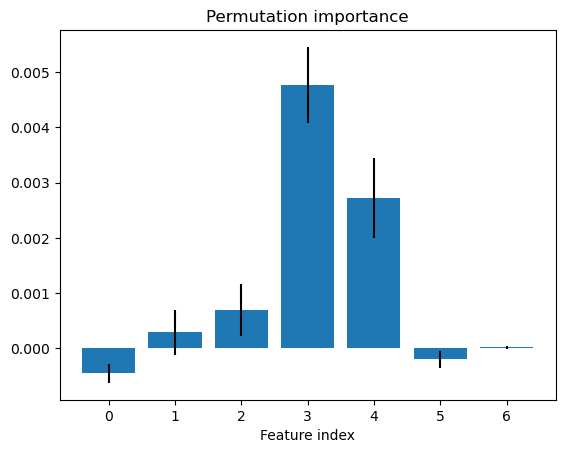

In [206]:
imp_tmp, imp_tmp_std = permutation_importances(
    cat_model, x_test_treat, y_test_treat, log_loss,
    iterations=500)

plt.bar(range(len(imp_tmp)), height=imp_tmp, yerr=imp_tmp_std)
plt.title("Permutation importance")
plt.xlabel("Feature index")
plt.show()
plt.close()

We can see that Feature `V4` (index at x-axis label is off by 1 w.r.t. feature names) has the highest impact, followed by `V5`. Feature `V3`, a feature where we have previously seen significant differences in the behaviour of purchasing and non-purchasing customers, is only having a minor impact, so is the Gaussian feature `V2`. Other features have no or even a negative impact on the model results.

Unfortunately, since no domain-specific information is given for the features, we cannot discuss the possible reasons for the importance results in detail but nevertheless I always find these importance scores useful.

There are also many other interesting feature important scores, for example shapley values, but for the additional analyses not to cover too much of this notebook, I will stop for now and fill in the `promotion_strategy` function as requested in the assignment.

# Step 5: Final performance evaluation

In [207]:
# save current catboost model
cat_model.save_model("./catboost_model.cbm")

In [210]:
def promotion_strategy(df):
    """Promotion strategy to select users that should be targeted by the
    promotion
    
    Args:
        df (pandas.DataFrame): Pandas dataframe containing test set
            Dataframe should contain the features 'V1' to' V7'
    
    Returns:
        numpy.ndarray: Array containing string 'Yes' for customers that should
        receive the promotion according to the model, 'No' for customers that 
        shouldn't receive it.
        
        Example:
        array(['Yes', 'Yes', 'No'])
        indicating the first two users would recieve the promotion and 
        the last should not.
    """
    # load current catboost model
    tmp_model = CatBoostClassifier()
    tmp_model = tmp_model.load_model("./catboost_model.cbm")
    
    # predict using default threshold of 0.5
    preds = tmp_model.predict(df)
    
    # build promotion array
    promotion = np.full_like(preds, 'No', dtype='<U3')
    promotion[preds == 1] = 'Yes'

    return promotion

In [211]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0199.

Your nir with this strategy is 446.00.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.019900016126431223, 446.0)

Using the default prediction threshold of 0.5, we achieve a better result both in terms of NIR and IRR compared to what the folks at Udacity came up with. This is already a good result but can probably be improved by additional hyperparameter optimization. However, I am quite satisfied with the result now and thus conclude the assignment here.